In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 45})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
n_inner_slices, n_outer_slices = 12, 20

# load test data

In [4]:
# Load Ar39
init = time.time()
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "UnseenTestData_11_10_2020", "Ar39", "Ar39_Snapshots")

fileprefix = "Snapshot1Ar39*"
dfall1ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot2Ar39*"
dfall2ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot3Ar39*"
dfall3ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot4Ar39*"
dfall4ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot5Ar39*"
dfall5ar39 = load_dataframe_from_files(dirin, fileprefix)

print("[Info] Loaded all 1, 2, 3, 4, 5 Ar39 Pileups in {:.2f} seconds".format(time.time() - init))

# Load Muons
init = time.time()
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "UnseenTestData_11_10_2020", "Muons", "Muons_Snapshots")

fileprefix = "SnapshotMuons*"
dfallmu = load_dataframe_from_files(dirin, fileprefix)
print("[Info] Loaded all Muons in {:.2f} seconds".format(time.time() - init))

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot2Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot3Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot4Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot5Ar39*
...................................................................................................
[Info] Loaded all 1, 2, 3, 4, 5 Ar39 Pileups in 14.94 seconds
[Info] Loading 100 files wt prefix:
SnapshotMuons*
...................................................................................................
[Info] Loaded all Muons in 0.78 

In [5]:
print("[Info] Test Set Composition:")
print("\tMuons: {}".format(len(dfallmu)))
print("\t1Ar39: {}".format(len(dfall1ar39)))
print("\t2Ar39: {}".format(len(dfall2ar39)))
print("\t3Ar39: {}".format(len(dfall3ar39)))
print("\t4Ar39: {}".format(len(dfall4ar39)))
print("\t5Ar39: {}".format(len(dfall5ar39)))

[Info] Test Set Composition:
	Muons: 15454
	1Ar39: 548429
	2Ar39: 274191
	3Ar39: 182778
	4Ar39: 137071
	5Ar39: 109648


# load models

In [6]:
from joblib import load
import tensorflow as tf

init = time.time()
rf = load("rf_10est_5depth.joblib")
cnn = tf.keras.models.load_model(os.path.join("..", "mu_vs_pileups", "models", "model_20200911-111046", "model.oncerepeat1.epoch02-valacc0.91889"))
print("[Info] Loaded models in {:.2f} seconds".format(time.time() - init))

[Info] Loaded models in 3.37 seconds


# data preparation

In [7]:
# prepare data
dfallmu["group"] = 0
dfall1ar39["group"] = 1
dfall2ar39["group"] = 2
dfall3ar39["group"] = 3
dfall4ar39["group"] = 4
dfall5ar39["group"] = 5
dfallmu["y"] = 1
dfall1ar39["y"] = 0
dfall2ar39["y"] = 0
dfall3ar39["y"] = 0
dfall4ar39["y"] = 0
dfall5ar39["y"] = 0
dfallar39 = pd.concat([dfall1ar39, dfall2ar39, dfall3ar39, dfall4ar39, dfall5ar39], axis=0)

In [8]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

In [9]:
# features for rforest
my_features = ["PEDetected_outer", "NActiveSlices_outer", "MeanNPEActive_outer", "SpatialVar_outer", "SpatialRange_outer", 
               "PEDetected_inner", "NActiveSlices_inner", "MeanNPEActive_inner", "SpatialVar_inner", "SpatialRange_inner",
               "PEDetected_tot", "NActiveSlices_tot", "MeanNPEActive_tot"]

init = time.time()
dfallmu["PEDetected_inner"] = dfallmu.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
dfallmu["NActiveSlices_inner"] = dfallmu.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
dfallmu["MeanNPEActive_inner"] = dfallmu.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
dfallmu["StdNPEActive_inner"] = dfallmu.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
dfallmu["SpatialRange_inner"] = dfallmu.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
dfallmu["SpatialVar_inner"] = dfallmu.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
dfallmu["SpatialStd_inner"] = dfallmu.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
dfallmu["PEDetected_outer"] = dfallmu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
dfallmu["NActiveSlices_outer"] = dfallmu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
dfallmu["MeanNPEActive_outer"] = dfallmu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
dfallmu["StdNPEActive_outer"] = dfallmu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
dfallmu["SpatialRange_outer"] = dfallmu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
dfallmu["SpatialVar_outer"] = dfallmu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
dfallmu["SpatialStd_outer"] = dfallmu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
dfallmu["PEDetected_tot"] = dfallmu["PEDetected_inner"] + dfallmu["PEDetected_outer"]
dfallmu["NActiveSlices_tot"] = dfallmu["NActiveSlices_inner"] + dfallmu["NActiveSlices_outer"]
dfallmu["MeanNPEActive_tot"] = dfallmu["PEDetected_tot"] / dfallmu["NActiveSlices_tot"]
dfallmu = dfallmu.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

init = time.time()
dfallar39["PEDetected_inner"] = dfallar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
dfallar39["NActiveSlices_inner"] = dfallar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
dfallar39["MeanNPEActive_inner"] = dfallar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
dfallar39["StdNPEActive_inner"] = dfallar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
dfallar39["SpatialRange_inner"] = dfallar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
dfallar39["SpatialVar_inner"] = dfallar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
dfallar39["SpatialStd_inner"] = dfallar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
dfallar39["PEDetected_outer"] = dfallar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
dfallar39["NActiveSlices_outer"] = dfallar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
dfallar39["MeanNPEActive_outer"] = dfallar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
dfallar39["StdNPEActive_outer"] = dfallar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
dfallar39["SpatialRange_outer"] = dfallar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
dfallar39["SpatialVar_outer"] = dfallar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
dfallar39["SpatialStd_outer"] = dfallar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
dfallar39["PEDetected_tot"] = dfallar39["PEDetected_inner"] + dfallar39["PEDetected_outer"]
dfallar39["NActiveSlices_tot"] = dfallar39["NActiveSlices_inner"] + dfallar39["NActiveSlices_outer"]
dfallar39["MeanNPEActive_tot"] = dfallar39["PEDetected_tot"] / dfallar39["NActiveSlices_tot"]
dfallar39 = dfallar39.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 2.963 sec
Compute Mu Outer features: 3.510 sec
Compute combined features: 0.008 sec
Compute Ar39 Inner features: 198.471 sec
Compute Ar39 Outer features: 257.788 sec
Compute combined features: 0.135 sec


In [10]:
data = pd.concat([dfallar39, dfallmu], axis=0)

# RForest predictions

In [11]:
X_rf, y_rf = data.loc[:, my_features], data.loc[:, "y"]
X_rf = np.array(X_rf)
y_rf = np.array(y_rf)

init = time.time()
data["y_rf_pred"] = rf.predict_proba(X_rf)[:, 1]
print("[Info] RForest predict in {:.3f} seconds".format(time.time() - init))

[Info] RForest predict in 0.550 seconds


# CNN prediction

In [12]:
X_cnn, y_cnn = data.iloc[:, 3:3+n_inner_slices+n_outer_slices], data.loc[:, "y"]
X_cnn = np.array(X_cnn)
X_cnn = tf.expand_dims(X_cnn, axis=-1)
y_cnn = np.array(y_cnn)

init = time.time()
data["y_cnn_pred"] = cnn.predict(X_cnn)
print("[Info] CNN predict in {:.3f} seconds".format(time.time() - init))

[Info] CNN predict in 54.776 seconds


# preliminary cuts: 5 PE and 4 Out NAS

In [13]:
data["cut_5npe"] = np.where(data.PEDetected_tot>=5, 1, 0)
data["cut_4nas"] = np.where(data.NActiveSlices_outer>=4, 1, 0)

In [14]:
len(data[(data.cut_4nas==1) & (data["group"]==0)]) / len(data[data.group==0])

0.841723825546784

# combo predictions

In [15]:
data["y_cut5npe_cnn"] = np.where(data.cut_5npe==0, 0, data.y_cnn_pred)
data["y_cut4nas_rf"] = np.where(data.cut_4nas==0, 0, data.y_rf_pred)

# evaluation

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cv
from sklearn.metrics import roc_curve, roc_auc_score

In [17]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(data.y, data.y_cut4nas_rf)
cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(data.y, data.y_cut5npe_cnn)

In [18]:
cnn_tp = len(data[(data.y==1) & (data.y_cut5npe_cnn>0.50)])
cnn_tn_1ar39 = len(data[(data.y==0) & (data.group==1) & (data.y_cut5npe_cnn<0.50)])
cnn_tn_2ar39 = len(data[(data.y==0) & (data.group==2) & (data.y_cut5npe_cnn<0.50)])
cnn_tn_3ar39 = len(data[(data.y==0) & (data.group==3) & (data.y_cut5npe_cnn<0.50)])
cnn_tn_4ar39 = len(data[(data.y==0) & (data.group==4) & (data.y_cut5npe_cnn<0.50)])
cnn_tn_5ar39 = len(data[(data.y==0) & (data.group==5) & (data.y_cut5npe_cnn<0.50)])

print("[Info] Per-class evaluation Cut 5 PE + CNN:")
print("\t TPR: {:.5f}".format(cnn_tp / len(data[data.y==1])))
print("\t TNR 1 Ar39: {:.5f}".format(cnn_tn_1ar39 / len(data[data.group==1])))
print("\t TNR 2 Ar39: {:.5f}".format(cnn_tn_2ar39 / len(data[data.group==2])))
print("\t TNR 3 Ar39: {:.5f}".format(cnn_tn_3ar39 / len(data[data.group==3])))
print("\t TNR 4 Ar39: {:.5f}".format(cnn_tn_4ar39 / len(data[data.group==4])))
print("\t TNR 5 Ar39: {:.5f}".format(cnn_tn_5ar39 / len(data[data.group==5])))

[Info] Per-class evaluation Cut 5 PE + CNN:
	 TPR: 0.84671
	 TNR 1 Ar39: 0.95540
	 TNR 2 Ar39: 0.87590
	 TNR 3 Ar39: 0.81151
	 TNR 4 Ar39: 0.79266
	 TNR 5 Ar39: 0.78259


In [19]:
rf_tp = len(data[(data.y==1) & (data.y_cut4nas_rf>0.50)])
rf_tn_1ar39 = len(data[(data.y==0) & (data.group==1) & (data.y_cut4nas_rf<0.50)])
rf_tn_2ar39 = len(data[(data.y==0) & (data.group==2) & (data.y_cut4nas_rf<0.50)])
rf_tn_3ar39 = len(data[(data.y==0) & (data.group==3) & (data.y_cut4nas_rf<0.50)])
rf_tn_4ar39 = len(data[(data.y==0) & (data.group==4) & (data.y_cut4nas_rf<0.50)])
rf_tn_5ar39 = len(data[(data.y==0) & (data.group==5) & (data.y_cut4nas_rf<0.50)])

print("[Info] Per-class evaluation Cut 5 PE + CNN:")
print("\t TPR: {:.5f}".format(rf_tp / len(data[data.y==1])))
print("\t TNR 1 Ar39: {:.5f}".format(rf_tn_1ar39 / len(data[data.group==1])))
print("\t TNR 2 Ar39: {:.5f}".format(rf_tn_2ar39 / len(data[data.group==2])))
print("\t TNR 3 Ar39: {:.5f}".format(rf_tn_3ar39 / len(data[data.group==3])))
print("\t TNR 4 Ar39: {:.5f}".format(rf_tn_4ar39 / len(data[data.group==4])))
print("\t TNR 5 Ar39: {:.5f}".format(rf_tn_5ar39 / len(data[data.group==5])))

[Info] Per-class evaluation Cut 5 PE + CNN:
	 TPR: 0.82665
	 TNR 1 Ar39: 0.99642
	 TNR 2 Ar39: 0.95090
	 TNR 3 Ar39: 0.84617
	 TNR 4 Ar39: 0.73056
	 TNR 5 Ar39: 0.61339


# Plot distribution based on NAS outer

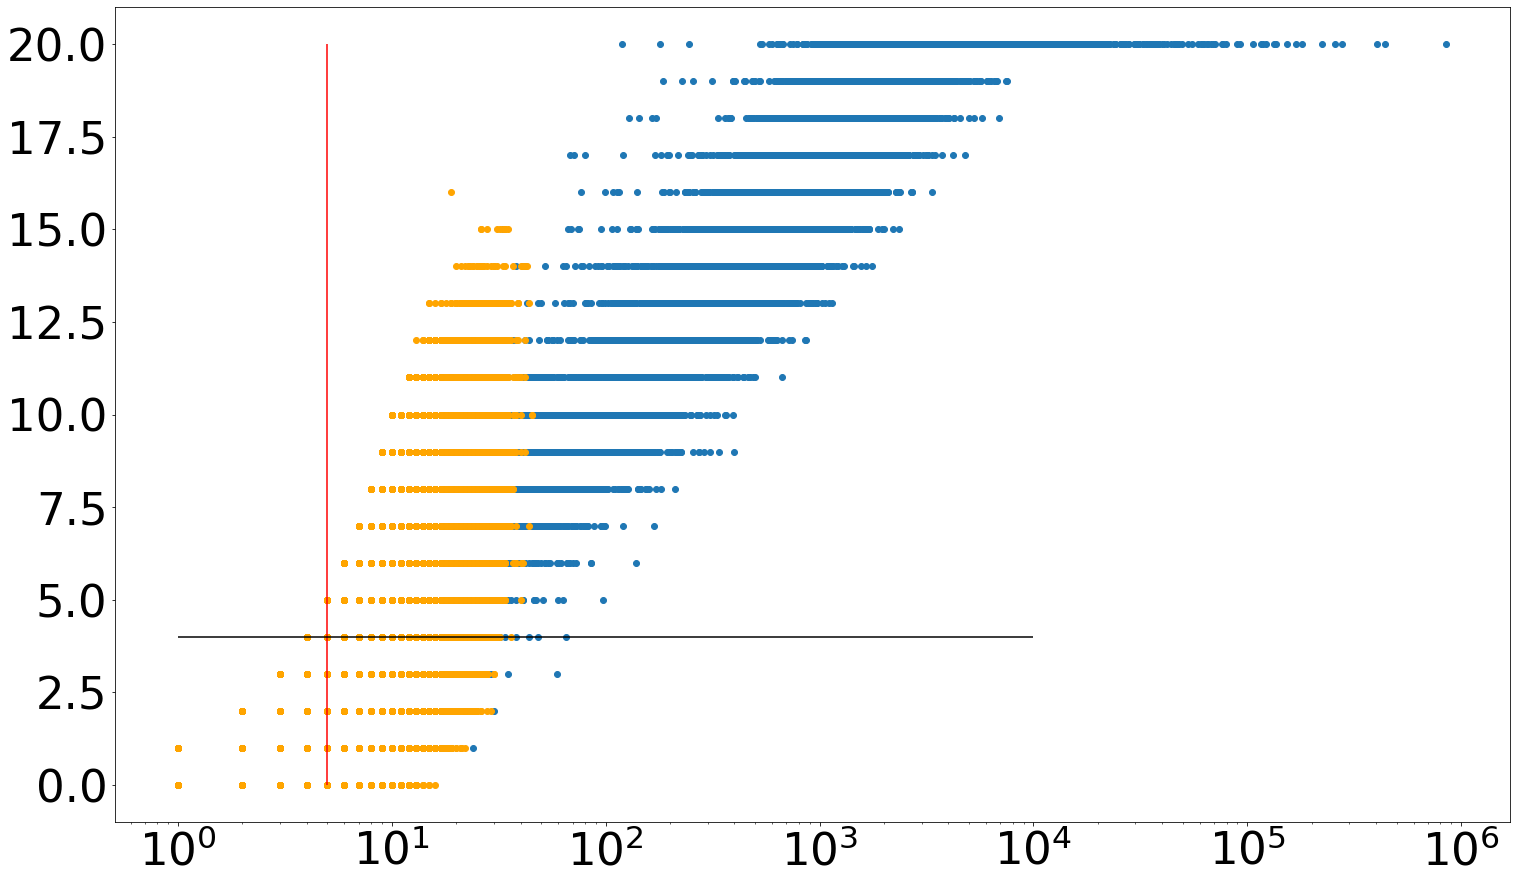

In [11]:
bins = np.linspace(0, 20, 21)
plt.scatter(dfallmu.PEDetected_tot, dfallmu.NActiveSlices_outer)
plt.scatter(dfallar39.PEDetected_tot, dfallar39.NActiveSlices_outer, color="orange")
plt.xscale("log")
plt.vlines(5, 0, 20, color="r")
plt.hlines(4, 1, 10000, color="k")
plt.show()

In [12]:
len(dfallmu[dfallmu.PEDetected_tot>50]) / len(dfallmu)

0.7061602174194384

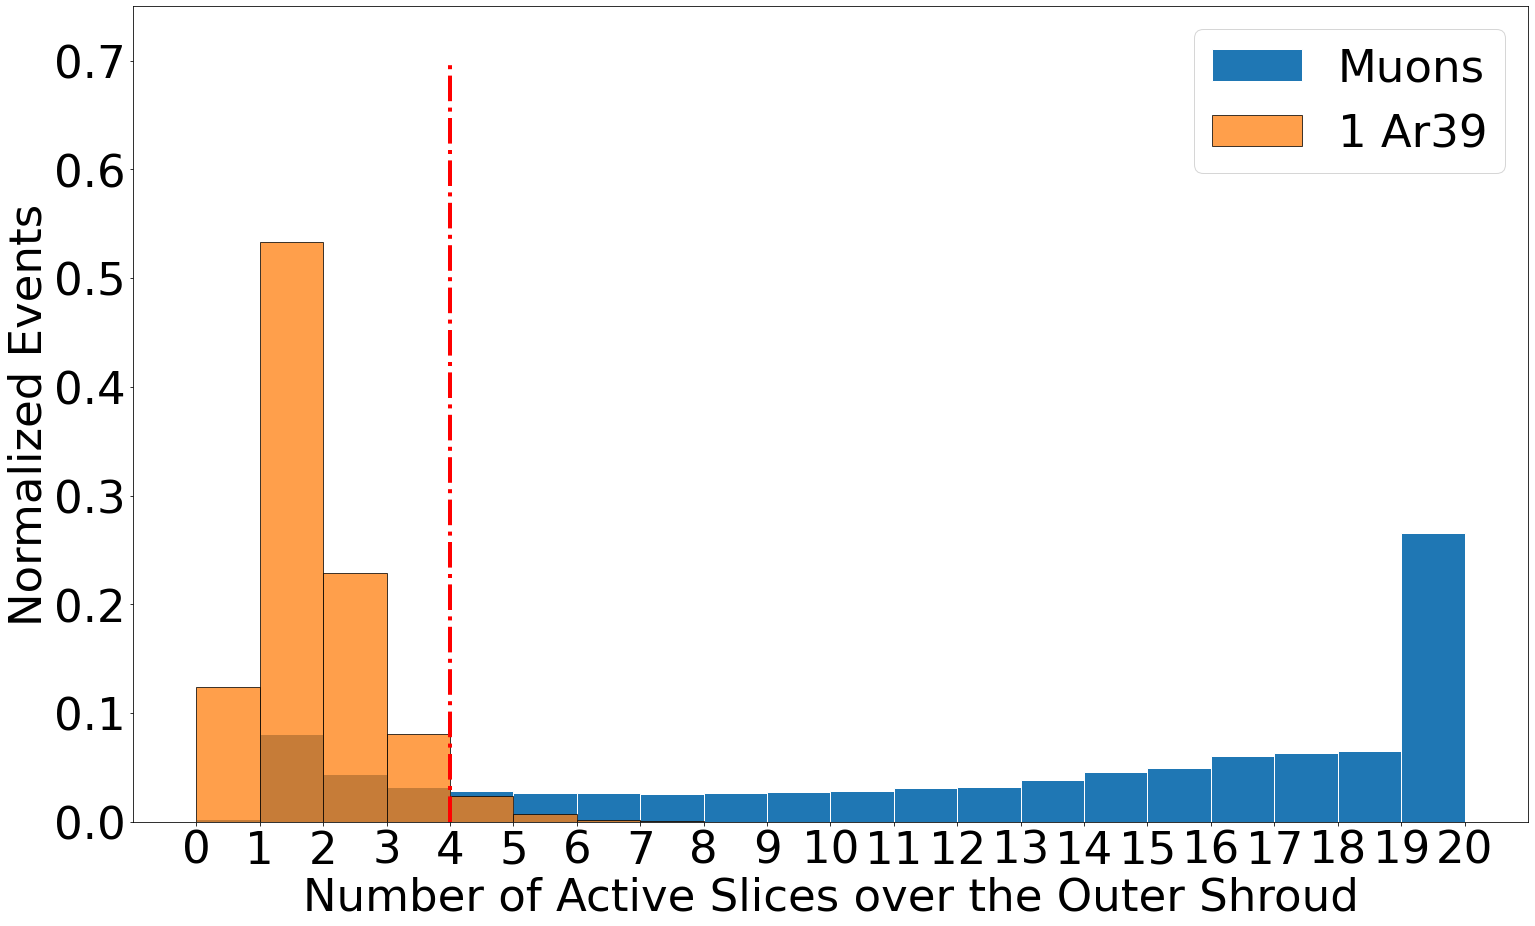

In [13]:
bins = np.linspace(0, 20, 21)
alpha = 0.6
plt.hist(dfallmu.NActiveSlices_outer, bins=bins, density=True, label="Muons", edgecolor="w")
plt.hist(dfallar39[dfallar39.group==1].NActiveSlices_outer, bins=bins, density=True, label="1 Ar39", edgecolor="k", alpha=.75)
#plt.hist(dfallar39[dfallar39.group==3].NActiveSlices_outer, bins=bins, density=True, label="3 Ar39", alpha=alpha)
#plt.hist(dfallar39[dfallar39.group==5].NActiveSlices_outer, bins=bins, density=True, label="5 Ar39", alpha=alpha)
plt.vlines(4, 0, .7, color="r", linestyles="dashdot", linewidth=4)
plt.xticks(range(21))
plt.ylim(0, .75)
plt.xlabel("Number of Active Slices over the Outer Shroud")
plt.ylabel("Normalized Events")
plt.legend()
plt.show()

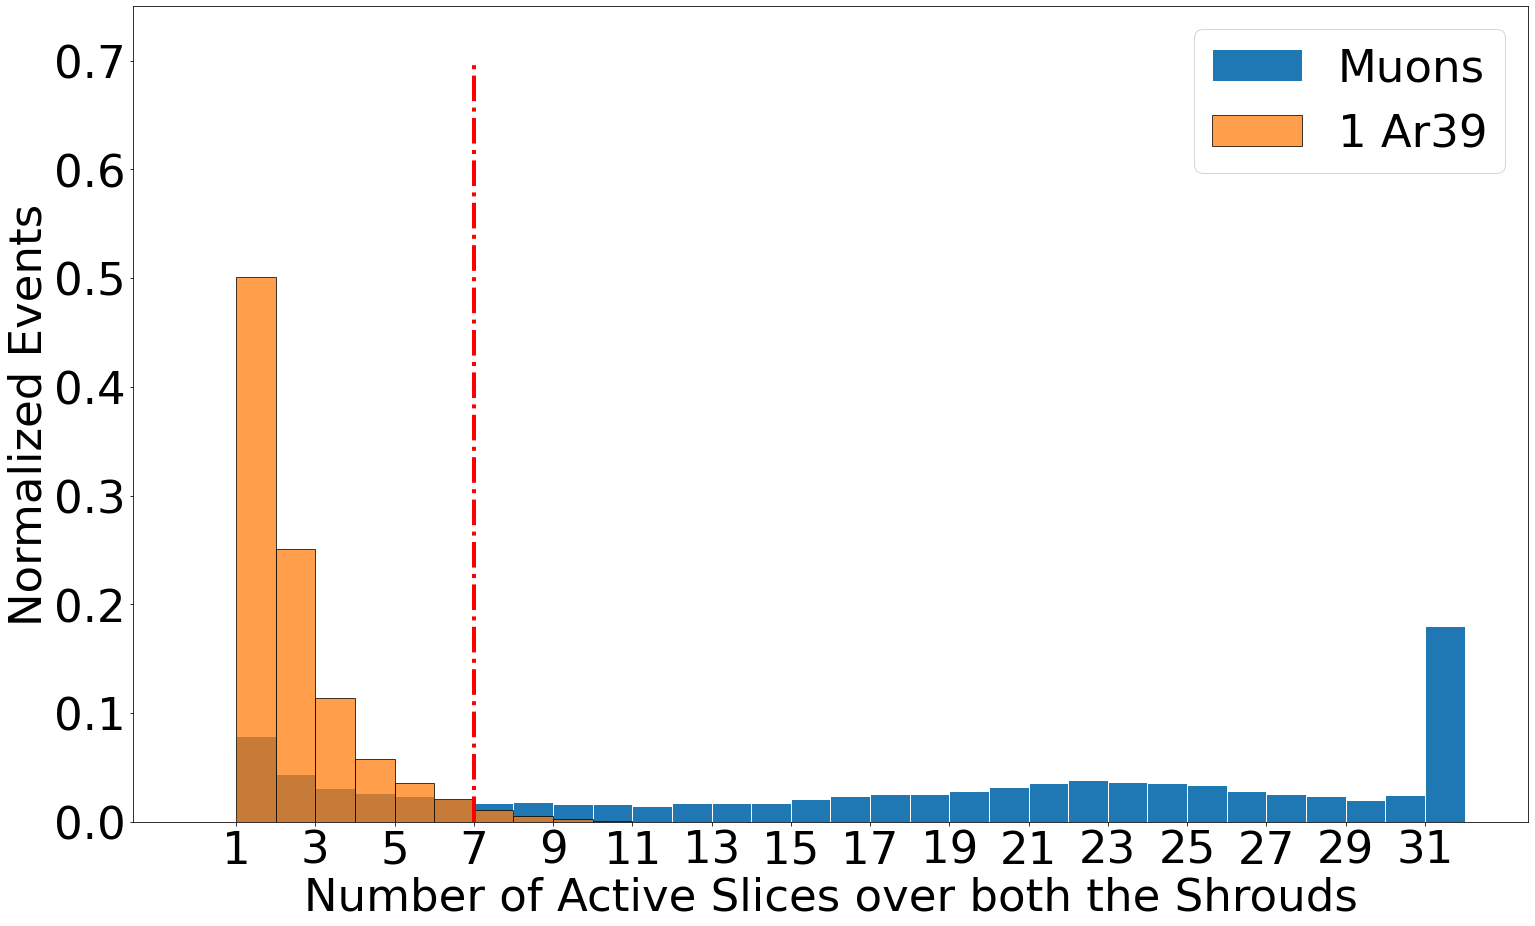

In [35]:
bins = np.linspace(0, 32, 33)
alpha = 0.6
plt.hist(dfallmu.NActiveSlices_tot, bins=bins, density=True, label="Muons", edgecolor="w")
plt.hist(dfallar39[dfallar39.group==1].NActiveSlices_tot, bins=bins, density=True, label="1 Ar39", edgecolor="k", alpha=.75)
plt.vlines(7, 0, .7, color="r", linestyles="dashdot", linewidth=4)
plt.xticks(range(1, 33, 2))
plt.ylim(0, .75)
plt.xlabel("Number of Active Slices over both the Shrouds")
plt.ylabel("Normalized Events")
plt.legend()
plt.show()

In [24]:
len(dfallar39[(dfallar39.group==1) & (dfallar39.NActiveSlices_outer>=4)]) / len(dfallar39[dfallar39.group==1])

0.032830138450009025

In [27]:
len(dfallar39[(dfallar39.group==1) & (dfallar39.NActiveSlices_tot>=7)]) / len(dfallar39[dfallar39.group==1])

0.019249529109510985

In [33]:
len(dfallmu[dfallmu.NActiveSlices_tot>=7]) / len(dfallmu)

0.7743626245632199

# ROC curve
To produce a good ROC curve, we cannot consider each background instance in the same way.
We propose to estimate the final FPR as weighted mean of the FPR of each bg subclass.

In [23]:
ar39_probs = [0,
              .980737931,
              .0190753528,
              .000185507806,
              .00000120270894,
              .00000000584817222]
ar39_weights = [prob / sum(ar39_probs) for prob in ar39_probs]

In [24]:
min_threshold, max_threshold = 0, 1
safe_increment = .1
cnn_thresholds, cnn_tprs, cnn_fprs = [], [], []
for threshold in np.linspace(min_threshold-safe_increment, 
                             max_threshold+safe_increment, 100):
    cnn_tpr = len(data[(data.y==1) & (data.y_cut5npe_cnn>threshold)]) / len(data[(data.y==1)])
    cnn_1fpr = len(data[(data.group==1) & (data.y_cut5npe_cnn>=threshold)]) / len(data[(data.group==1)])
    cnn_2fpr = len(data[(data.group==2) & (data.y_cut5npe_cnn>=threshold)]) / len(data[(data.group==2)])
    cnn_3fpr = len(data[(data.group==3) & (data.y_cut5npe_cnn>=threshold)]) / len(data[(data.group==3)])
    cnn_4fpr = len(data[(data.group==4) & (data.y_cut5npe_cnn>=threshold)]) / len(data[(data.group==4)])
    cnn_5fpr = len(data[(data.group==5) & (data.y_cut5npe_cnn>=threshold)]) / len(data[(data.group==5)])
    cnn_thresholds.append(threshold)
    cnn_tprs.append(cnn_tpr)
    cnn_fprs.append(ar39_weights[1] * cnn_1fpr + \
                    ar39_weights[2] * cnn_2fpr + \
                    ar39_weights[3] * cnn_3fpr + \
                    ar39_weights[4] * cnn_4fpr + \
                    ar39_weights[5] * cnn_5fpr)

In [25]:
rf_thresholds, rf_tprs, rf_fprs = [], [], []
for threshold in np.linspace(min_threshold-safe_increment, 
                             max_threshold+safe_increment, 100):
    rf_tpr = len(data[(data.y==1) & (data.y_cut4nas_rf>threshold)]) / len(data[(data.y==1)])
    rf_1fpr = len(data[(data.group==1) & (data.y_cut4nas_rf>=threshold)]) / len(data[(data.group==1)])
    rf_2fpr = len(data[(data.group==2) & (data.y_cut4nas_rf>=threshold)]) / len(data[(data.group==2)])
    rf_3fpr = len(data[(data.group==3) & (data.y_cut4nas_rf>=threshold)]) / len(data[(data.group==3)])
    rf_4fpr = len(data[(data.group==4) & (data.y_cut4nas_rf>=threshold)]) / len(data[(data.group==4)])
    rf_5fpr = len(data[(data.group==5) & (data.y_cut4nas_rf>=threshold)]) / len(data[(data.group==5)])
    rf_thresholds.append(threshold)
    rf_tprs.append(rf_tpr)
    rf_fprs.append(ar39_weights[1] * rf_1fpr + \
                   ar39_weights[2] * rf_2fpr + \
                   ar39_weights[3] * rf_3fpr + \
                   ar39_weights[4] * rf_4fpr + \
                   ar39_weights[5] * rf_5fpr)

[Info] Cut 5PE + CNN: Thr=0.5 => TPR: 84.671%, FPR: 4.693%
[Info] Cut 4NAS + RF: Thr=0.5 => TPR: 82.665%, FPR: 0.459%


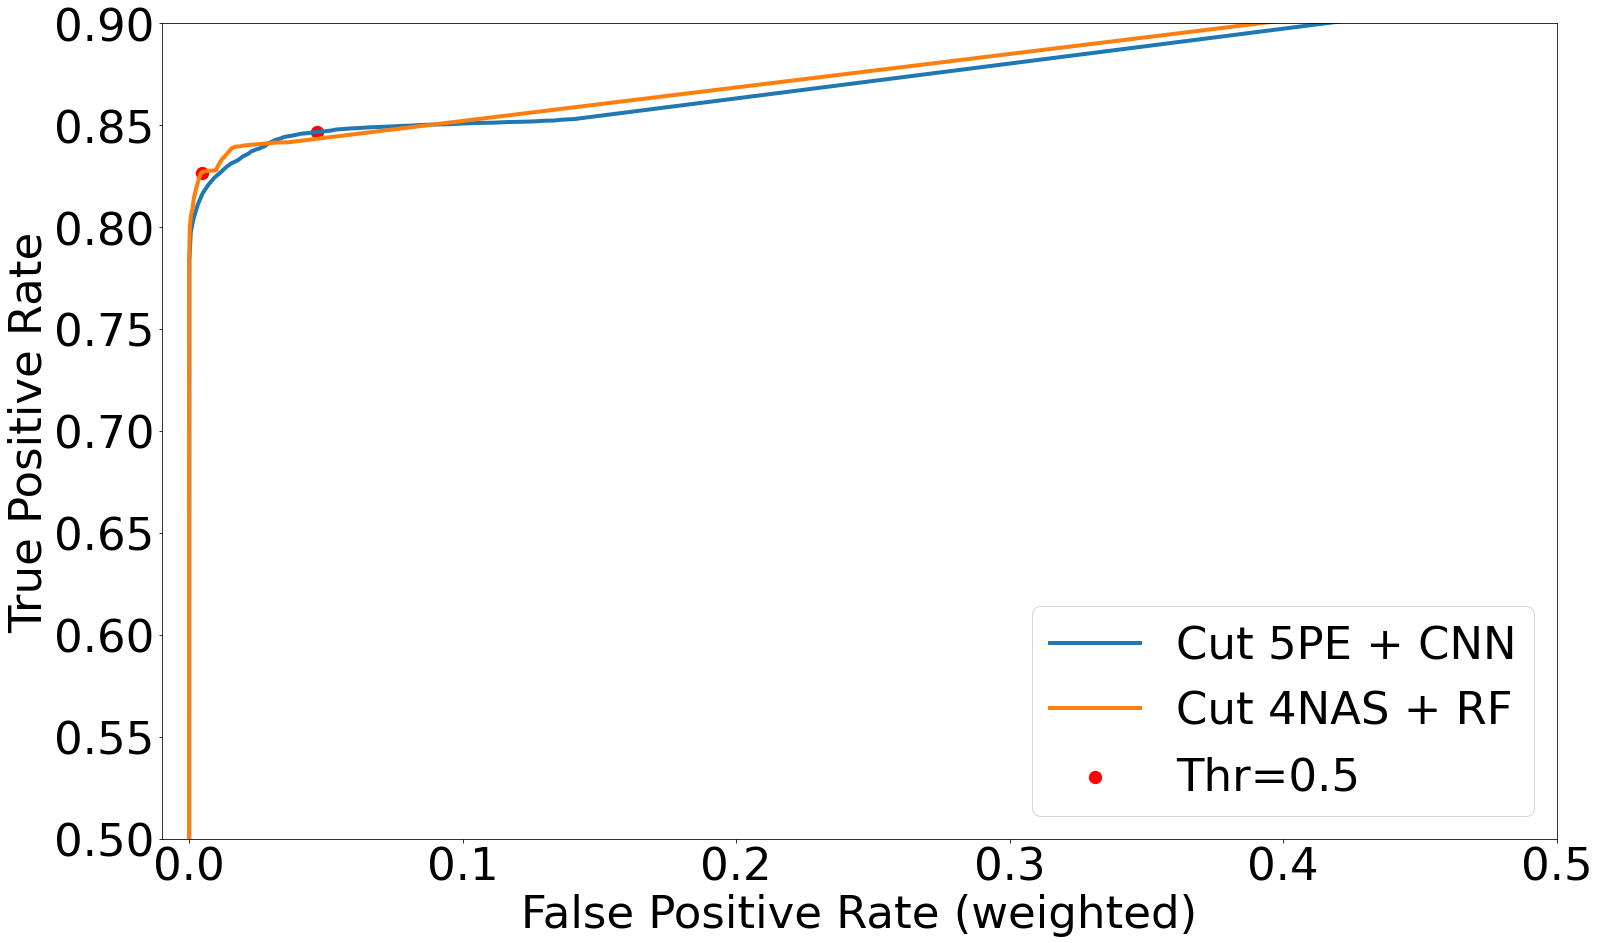

In [26]:
plt.plot(cnn_fprs, cnn_tprs, label="Cut 5PE + CNN", linewidth=4)
plt.plot(rf_fprs, rf_tprs, label="Cut 4NAS + RF", linewidth=4)

for t in [.5]:
    id_cnn = np.argmin(np.abs(np.array(cnn_thresholds) - t))
    plt.scatter(cnn_fprs[id_cnn], cnn_tprs[id_cnn], 
                label="Thr={}".format(t), s=150, c='r')
    print("[Info] Cut 5PE + CNN: Thr={:.1f} => TPR: {:.3f}%, FPR: {:.3f}%".format(cnn_thresholds[id_cnn], 
                                                                           cnn_tprs[id_cnn] * 100, 
                                                                           cnn_fprs[id_cnn] * 100))
for t in [.5]:
    id_rf = np.argmin(np.abs(np.array(rf_thresholds) - t))
    plt.scatter(rf_fprs[id_rf], rf_tprs[id_rf], 
               s=150, c='r')
    print("[Info] Cut 4NAS + RF: Thr={:.1f} => TPR: {:.3f}%, FPR: {:.3f}%".format(rf_thresholds[id_rf], 
                                                                           rf_tprs[id_rf] * 100, 
                                                                           rf_fprs[id_rf] * 100))

plt.legend()
plt.xlabel("False Positive Rate (weighted)")
plt.ylabel("True Positive Rate")
plt.xlim(-.010, .50)
plt.ylim(.50, .90)
plt.show()

In [27]:
cut_thresholds = []
cut_tprs = []
cut_fprs = []
for threshold in range(50):
    tpr = len(data[(data.y==1) & (data.NActiveSlices_outer>=threshold)]) / len(data[data.y==1])
    fpr1 = len(data[(data.group==1) & (data.NActiveSlices_outer>=threshold)]) / len(data[data.group==1])
    fpr2 = len(data[(data.group==2) & (data.NActiveSlices_outer>=threshold)]) / len(data[data.group==2])
    fpr3 = len(data[(data.group==3) & (data.NActiveSlices_outer>=threshold)]) / len(data[data.group==3])
    fpr4 = len(data[(data.group==4) & (data.NActiveSlices_outer>=threshold)]) / len(data[data.group==4])
    fpr5 = len(data[(data.group==5) & (data.NActiveSlices_outer>=threshold)]) / len(data[data.group==5])
    cut_thresholds.append(threshold)
    cut_tprs.append(tpr)
    cut_fprs.append(ar39_weights[1] * fpr1 + \
                    ar39_weights[2] * fpr2 + \
                    ar39_weights[3] * fpr3 + \
                    ar39_weights[4] * fpr4 + \
                    ar39_weights[5] * fpr5)

[Info] Cut 4NAS + RF: Thr=0.49 => TPR: 82.665%, FPR: 0.459%
[Info] Cut 4NAS: Thr=4 NAS=> TPR: 84.172%, FPR: 3.655%


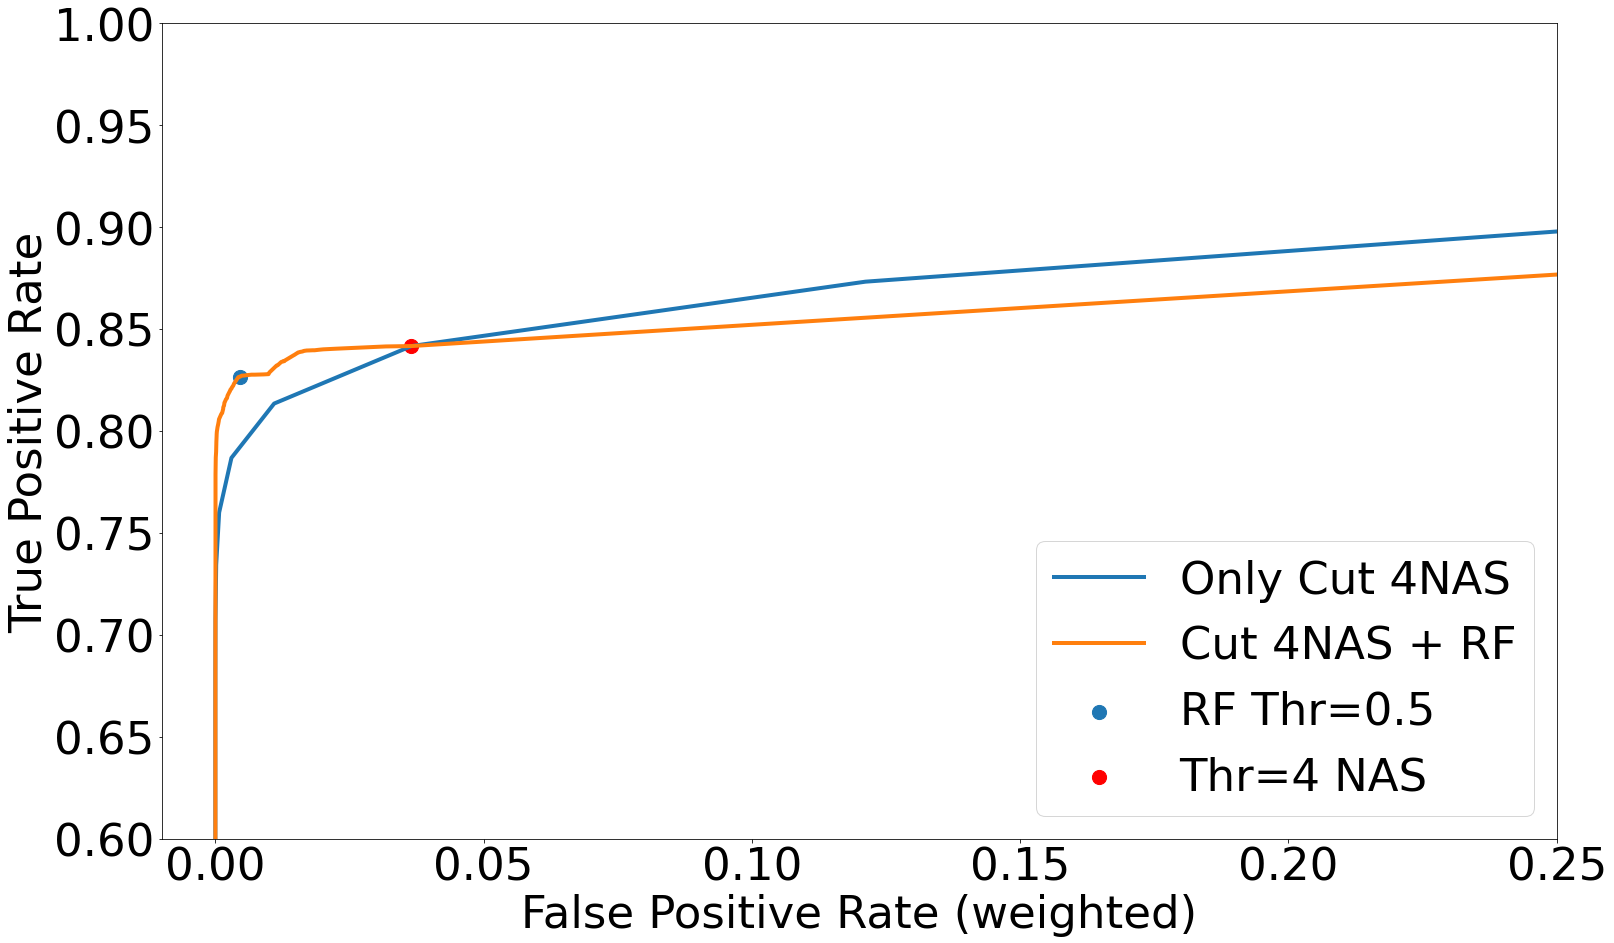

In [28]:
plt.plot(cut_fprs, cut_tprs, linewidth=4, label="Only Cut 4NAS")
plt.plot(rf_fprs, rf_tprs, linewidth=4, label="Cut 4NAS + RF")

for t in [.5]:
    id_rf = np.argmin(np.abs(np.array(rf_thresholds) - t))
    plt.scatter(rf_fprs[id_rf], rf_tprs[id_rf], 
                label="RF Thr={}".format(t), s=200)
    print("[Info] Cut 4NAS + RF: Thr={:.2f} => TPR: {:.3f}%, FPR: {:.3f}%".format(rf_thresholds[id_rf], 
                                                                           rf_tprs[id_rf] * 100, 
                                                                           rf_fprs[id_rf] * 100))

for t in [4]:
    id_cut = np.argmin(np.abs(np.array(cut_thresholds) - t))
    plt.scatter(cut_fprs[id_cut], cut_tprs[id_cut], 
                label="Thr={} NAS".format(t), s=200, c='r')
    print("[Info] Cut 4NAS: Thr={:.0f} NAS=> TPR: {:.3f}%, FPR: {:.3f}%".format(cut_thresholds[id_cut], 
                                                                           cut_tprs[id_cut] * 100, 
                                                                           cut_fprs[id_cut] * 100))

plt.legend()
plt.xlabel("False Positive Rate (weighted)")
plt.ylabel("True Positive Rate")
plt.xlim(-.01, .25)
plt.ylim(.60, 1)
plt.show()

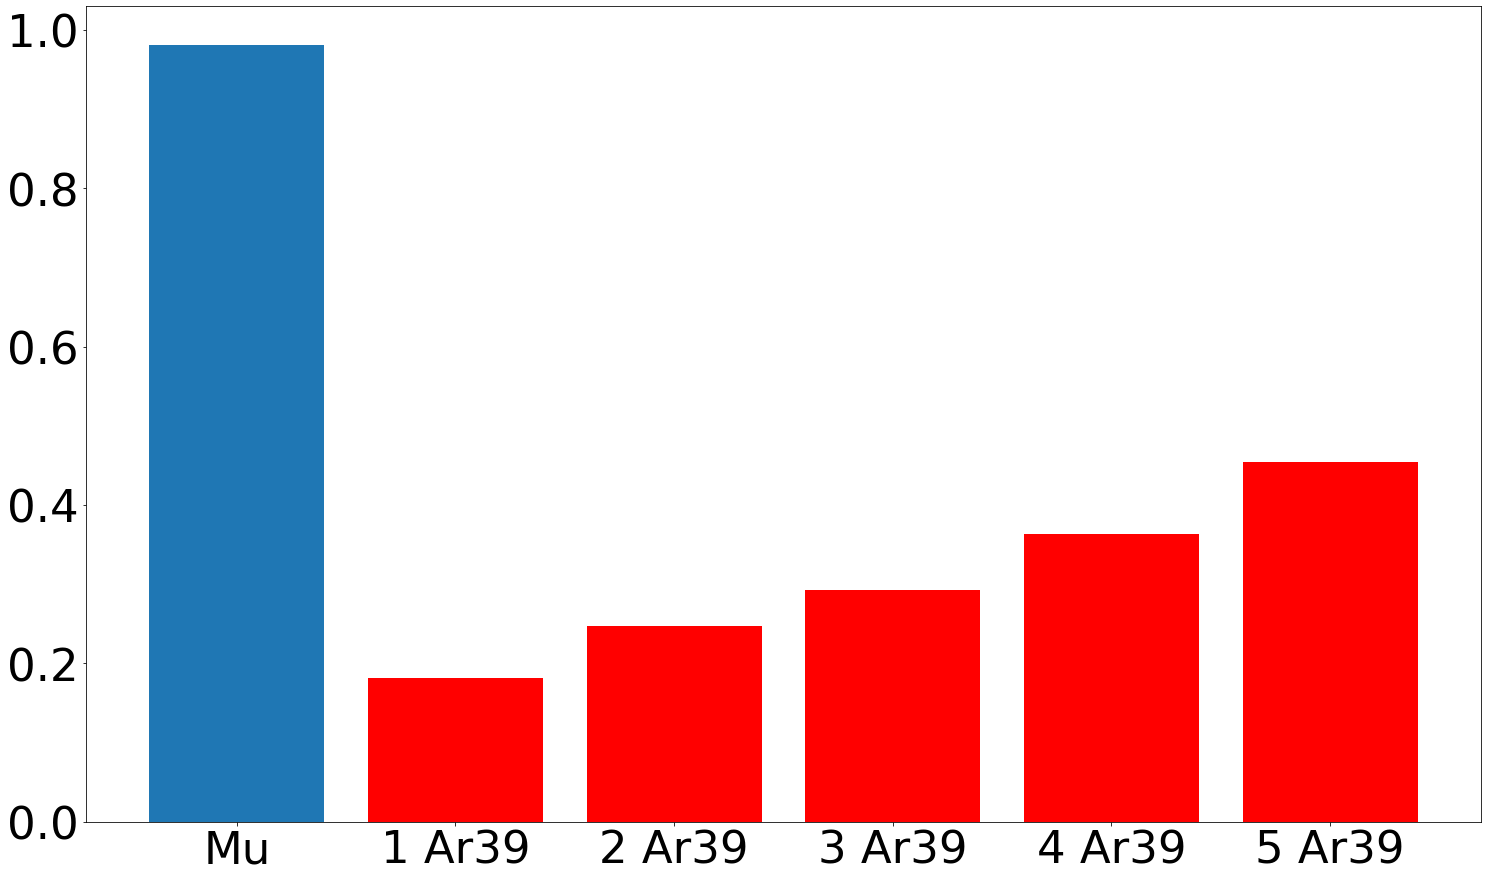

In [3]:
# these are the tpr/tnr of rf on validation set, taken from previous notebook!
true_rates_training = [0.98087, 0.1813, 0.24757, 0.29246, 0.3635, 0.45465]
plt.bar(range(len(true_rates_training)), true_rates_training)
plt.bar(range(1, len(true_rates_training)), true_rates_training[1:], color="red")
plt.xticks(range(len(true_rates_training)), ["Mu", "1 Ar39",
                                             "2 Ar39", "3 Ar39", 
                                             "4 Ar39", "5 Ar39"])
plt.show()

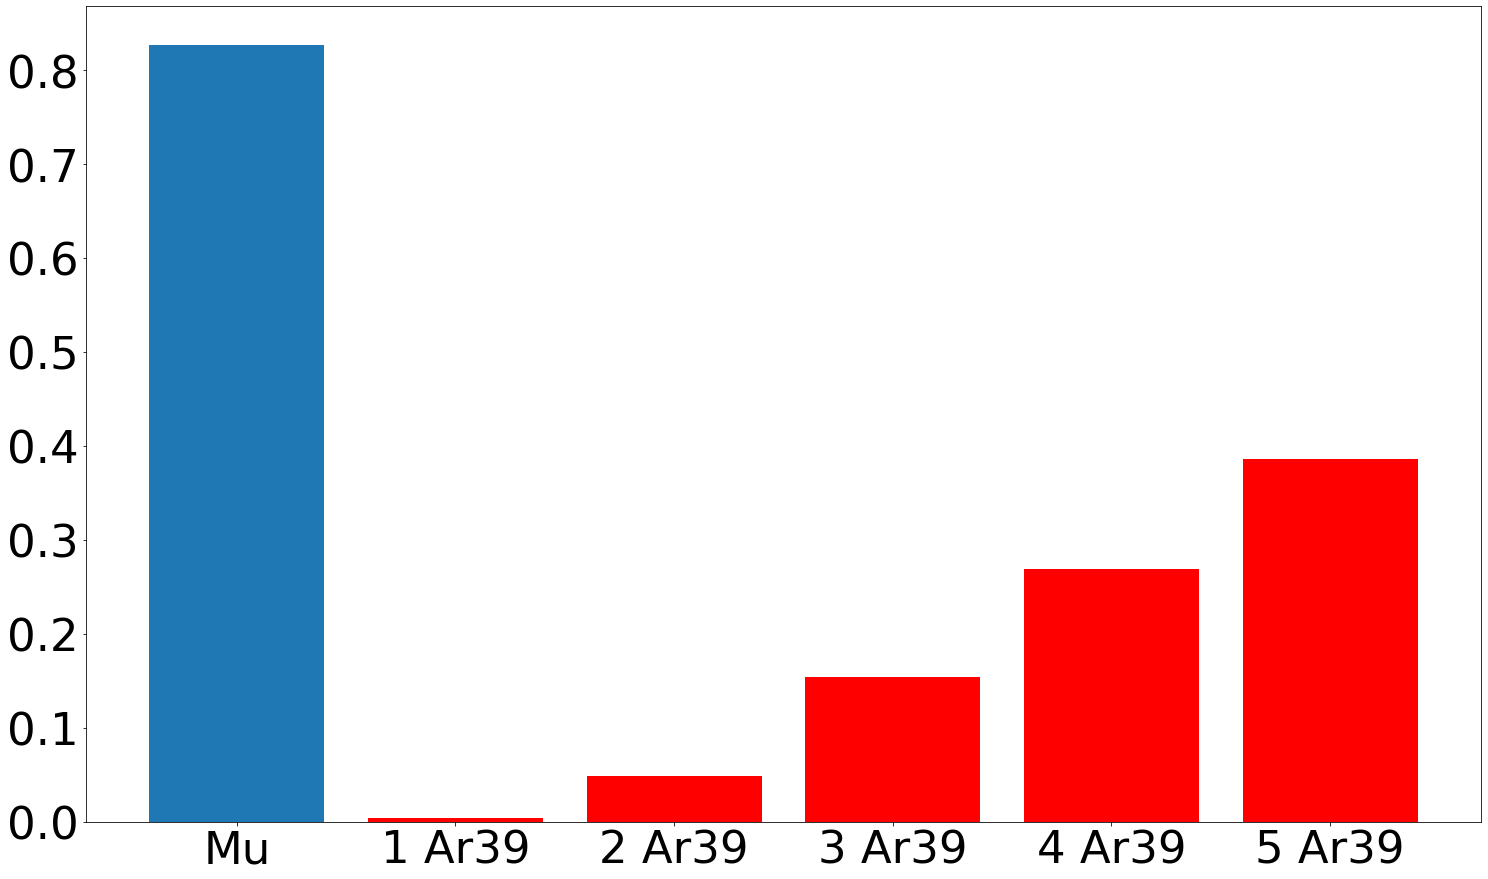

In [30]:
rf_tpr = len(data[(data.y==1) & (data.y_cut4nas_rf>.5)]) / len(data[(data.y==1)])
rf_fpr1 = len(data[(data.y==0) & (data.group==1) & (data.y_cut4nas_rf>=.5)]) / len(data[(data.y==0) & (data.group==1)])
rf_fpr2 = len(data[(data.y==0) & (data.group==2) & (data.y_cut4nas_rf>=.5)]) / len(data[(data.y==0) & (data.group==2)])
rf_fpr3 = len(data[(data.y==0) & (data.group==3) & (data.y_cut4nas_rf>=.5)]) / len(data[(data.y==0) & (data.group==3)])
rf_fpr4 = len(data[(data.y==0) & (data.group==4) & (data.y_cut4nas_rf>=.5)]) / len(data[(data.y==0) & (data.group==4)])
rf_fpr5 = len(data[(data.y==0) & (data.group==5) & (data.y_cut4nas_rf>=.5)]) / len(data[(data.y==0) & (data.group==5)])
true_rates_test = [rf_tpr, rf_fpr1, rf_fpr2, rf_fpr3, rf_fpr4, rf_fpr5]
plt.bar(range(len(true_rates_test)), true_rates_test)
plt.bar(range(1, len(true_rates_test)), true_rates_test[1:], color="red")
plt.xticks(range(len(true_rates_test)), ["Mu", "1 Ar39",
                                             "2 Ar39", "3 Ar39", 
                                             "4 Ar39", "5 Ar39"])
plt.show()

In [31]:
# plot PE distribution
len(dfallmu[dfallmu.pedetected>60]) / len(dfallmu)

0.694448039342565

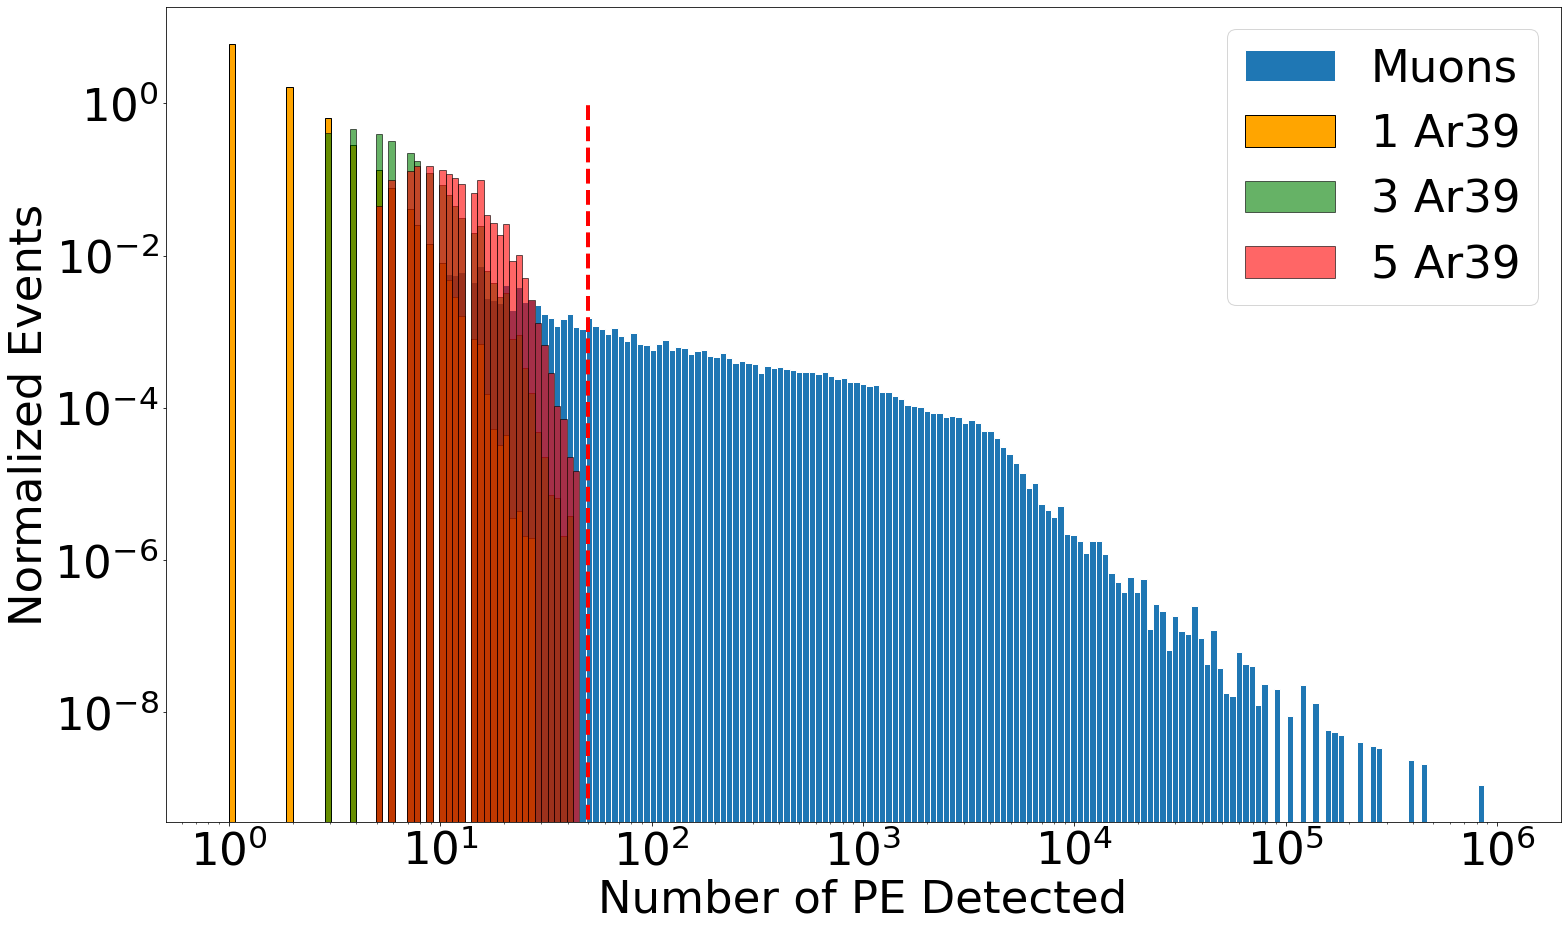

In [32]:
bins = np.logspace(0, 6, 200)
alpha = 0.6
plt.hist(dfallmu.pedetected, bins=bins, density=True, edgecolor='w', label="Muons")
plt.hist(dfall1ar39.pedetected, bins=bins, density=True, color='orange', edgecolor='k', label="1 Ar39")
plt.hist(dfall3ar39.pedetected, bins=bins, density=True, color='green', alpha=alpha, edgecolor='k', label="3 Ar39")
plt.hist(dfall5ar39.pedetected, bins=bins, density=True, color='red', alpha=alpha, edgecolor='k', label="5 Ar39")
plt.vlines(50, 0, 1, color='r', linewidth=4, linestyle='dashed')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of PE Detected")
plt.ylabel("Normalized Events")
plt.legend()
plt.show()

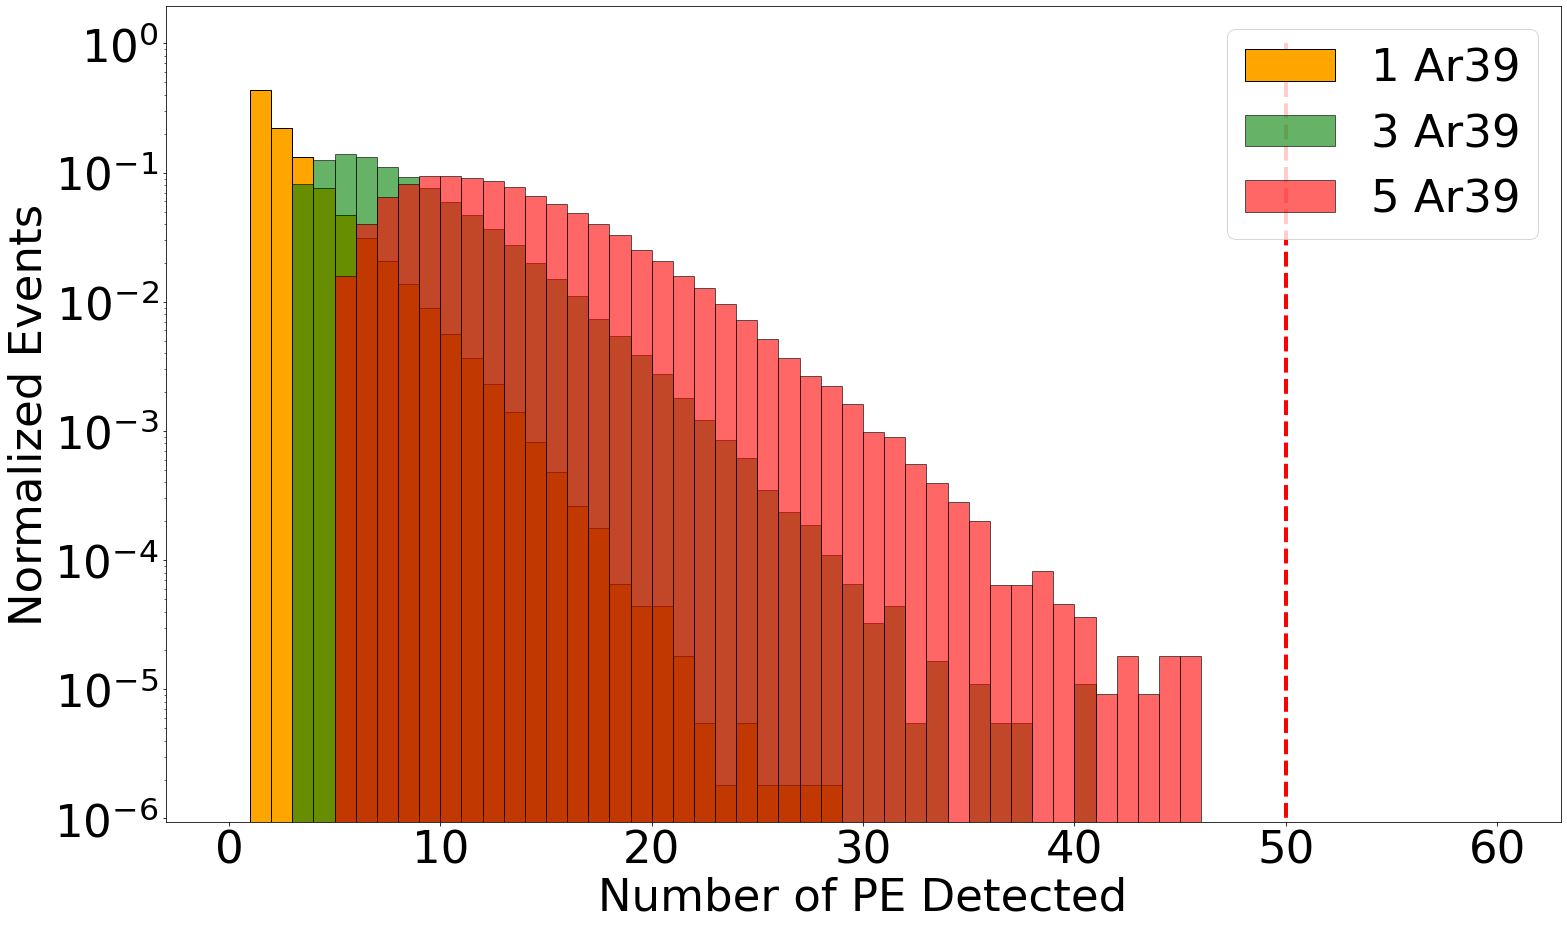

In [33]:
bins = np.linspace(0, 60, 61)
alpha = 0.6
plt.hist(dfall1ar39.pedetected, bins=bins, density=True, color='orange', edgecolor='k', label="1 Ar39")
plt.hist(dfall3ar39.pedetected, bins=bins, density=True, color='green', alpha=alpha, edgecolor='k', label="3 Ar39")
plt.hist(dfall5ar39.pedetected, bins=bins, density=True, color='red', alpha=alpha, edgecolor='k', label="5 Ar39")
plt.vlines(50, 0, 1, color='r', linewidth=4, linestyle='dashed')
plt.yscale("log")
plt.xlabel("Number of PE Detected")
plt.ylabel("Normalized Events")
plt.legend()
plt.show()

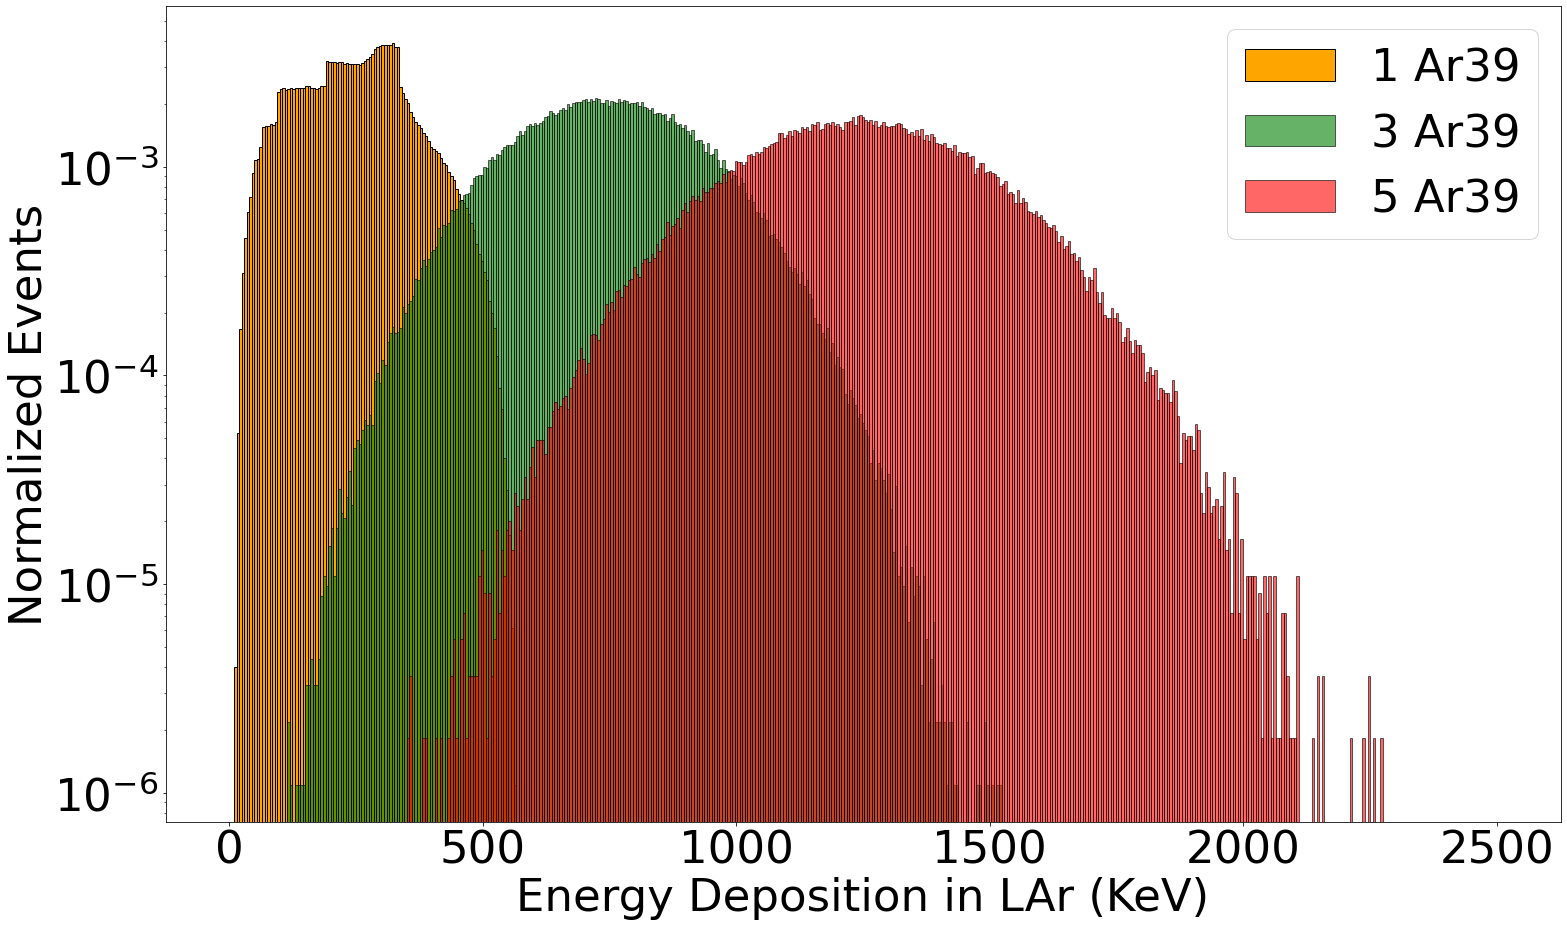

In [34]:
bins = np.linspace(0, 2500, 500)
alpha = 0.6
plt.hist(dfall1ar39.energydeposition, bins=bins, density=True, color='orange', edgecolor='k', label="1 Ar39")
plt.hist(dfall3ar39.energydeposition, bins=bins, density=True, color='green', alpha=alpha, edgecolor='k', label="3 Ar39")
plt.hist(dfall5ar39.energydeposition, bins=bins, density=True, color='red', alpha=alpha, edgecolor='k', label="5 Ar39")
plt.yscale("log")
plt.xlabel("Energy Deposition in LAr (KeV)")
plt.ylabel("Normalized Events")
plt.legend()
plt.show()